In [1]:
import sys, os

#Our project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), os.pardir))
sys.path.append(PROJECT_ROOT)

#Local packages loaded from src specifying useful constants, and our custom loader
from util.constants import DATA_PATHS
from util.dataset import OcelotDatasetLoader, PixelThreshold
from util.unet import Unet
from util.evaluate import evaluate

#other modules of interest
import torch
from torch.utils.data import DataLoader
import torchmetrics
from torchvision import transforms as transf
from PIL import Image
import numpy as np
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
from monai.losses import DiceCELoss, DiceLoss, MaskedDiceLoss
import copy

In [2]:
my_device = torch.device(device = 'cuda' if torch.cuda.is_available() else 'cpu')
pin_memory = True if my_device == 'cuda' else False
d_type_f32 = torch.float32
batch_size = 1
learning_rate= 1e-3
weight_decay = 1e-3
nepochs = 10
val_percent=0.1
train_percent = 1 - val_percent
image_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor()])
mask_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor(), PixelThreshold(lower_thresh=1, upper_thresh=255)])

#First we need to specify some info on our model: we have 3 channels RGB, 1 class: tissue
model = Unet(n_channels=3, n_classes=1)

print(my_device)

cuda


In [3]:
#Load our data in our special dataloader
TissTrainData = OcelotDatasetLoader(paths = DATA_PATHS,
                                    dataToLoad = 'Tissue',
                                    image_transforms=image_transforms,
                                    mask_transforms=mask_transforms)

#Establish a train/validation split size
TrainValSplit = [int(0.8*len(TissTrainData)), len(TissTrainData) - int(0.8*len(TissTrainData))]

#Establish our training and validation data using torch's built in random_split on our own formatted data
TrainingData, ValidationData = torch.utils.data.random_split(TissTrainData, [train_percent, val_percent])

In [4]:
#Load into Pytorch's built in DataLoader
TissTrainLoader = DataLoader(TissTrainData, batch_size=batch_size, num_workers=4)

TissValLoader = DataLoader(ValidationData, batch_size=batch_size, num_workers=4)

In [5]:
import torch
from tqdm import tqdm
from monai.losses import DiceCELoss

@torch.inference_mode()
def fevaluate(model, dataloader, device, amp):
    #Set to evaluation mode
    model.eval()
    metric_sum = 0
    n_samples = len(dataloader.dataset)
    n_batches = n_samples / dataloader.batch_size
    loss_metric = DiceCELoss(sigmoid=True)

    #No need to waste memory resources for gradients if we are not using backpropagation
    with torch.autocast(device.type if device.type == 'cuda' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=n_samples, desc='Validation round', unit='batch', leave=False):
            images, true_masks = batch[0], batch[1]
            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last if amp==True else torch.preserve_format)
            true_masks = true_masks.to(device=device, dtype=torch.float32)
            model.to(device)
            
            #Predict from imagenotebooks/JL_notebook_1.ipynb
            pred_masks = model(images)

            #Squeeze our masks
            pred_masks = pred_masks.float()

            score = loss_metric(pred_masks, true_masks.float()).detach().cpu()
            
            metric_sum += score.item()
    
    model.train()
    
    avg_metric = metric_sum/n_batches
    return avg_metric

In [6]:
def tiss_training_loop(
    model,
    device,
    epochs,
    batch_size:         int = 128,
    learning_rate:      float = 0.01,
    val_percent:        float = 0.2,
    amp:                bool = False,
    weight_decay:       float = 1e-3,
    momentum:           float = 0.98,
    gradient_clipping:  float = 1.0,
    image_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor()]),
    mask_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor(), PixelThreshold(lower_thresh=1, upper_thresh=255)]),
    filepath = None
):
    #Loading our data, performing necessary splits (update with test set in future), and send to loader
    print("Loading Ocelot dataset...")

    training_data = OcelotDatasetLoader(paths=DATA_PATHS,
                                        dataToLoad='Tissue',
                                        image_transforms=image_transforms,
                                        mask_transforms=mask_transforms)
    train_percent = 1 - val_percent
    train_N, val_N = [int(train_percent*len(training_data)), 
                      int(val_percent*len(training_data))]
    train_split, val_split = torch.utils.data.random_split(training_data, 
                                                           [train_percent, val_percent])
    train_loader = DataLoader(train_split, 
                              batch_size=batch_size, 
                              num_workers=4)
    val_loader = DataLoader(val_split, 
                            batch_size=batch_size, 
                            num_workers=4)
    N_batches_train = train_N/train_loader.batch_size
    N_batches_val = val_N/val_loader.batch_size

    print(f"Found {len(training_data)} data samples.")   
        
    #Initialize optimizer, loss, learning rate, and loss scaling
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                momentum=momentum,
                                weight_decay=weight_decay,
                                maximize=False)
    
    criterion = DiceCELoss(sigmoid=True) #TODO: IMPLEMENT BEHAVIOR FOR NON BINARY SEGMENTATION (ensure model.n_classes=1 for now)


    #we use max here as our purpose is to maximize our measured metric (DICE score of 1 is better: more mask similarity)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
    
    #Only for AMP. prevents loss of values due to switch between multiple formats
    grad_scaler = torch.cuda.amp.grad_scaler.GradScaler(enabled=amp)
    model.to(device)
    val_losses = []
    train_losses = []
    best_val = 0

    #Begin training
    for epoch in range(epochs):
        epoch_loss = 0
        model.train()

        with tqdm(total=train_N, desc=f'Epoch {epoch+1}/{epochs}') as progress_bar:
                        
            for batch in train_loader:
                images, true_masks = batch[0], batch[1]
                assert images.shape[1] == model.n_channels, f"Expected {model.n_channels} channels from image but received {images.shape[1]} channels instead."
                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last if amp==True else torch.preserve_format)
                true_masks = true_masks.to(device=device, dtype=torch.float32)

                with torch.autocast(device.type if device.type == 'cuda' else 'cpu', enabled=amp):
                    infer_masks = model(images)
                    
                    if model.n_classes == 1:
                        loss = criterion(infer_masks, true_masks.float())
                        epoch_loss += loss.detach().cpu().item()
                        #loss += 0.5 * dice_score #TODO: loss += dice score?
                    
                    else:
                        #TODO: EVALUATE CRITERION FOR MULTICLASS SEGMENTATION
                        loss = ...
                        return NotImplementedError

                optimizer.zero_grad()

                #Scales w/ AMP enabled from loss and does backprop
                grad_scaler.scale(loss).backward()

                #Grad clipping restricts gradient to a range. Research vanishing gradient for more.
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                
                #Step the optimizer for new model parameters (keeping grad scaling in mind assuming AMP)
                grad_scaler.step(optimizer)
                grad_scaler.update()
                progress_bar.update(images.shape[0])
            
            #Calculate train loss
            train_loss = epoch_loss/N_batches_train
            train_losses.append(train_loss)

            #Move on to validation loss
            val_loss = fevaluate(model, val_loader, device, amp=False) #TODO: UPDATE EVALUATION METHOD FOR MULTICLASS
            
            print(f"Val loss:   {val_loss}")
            print(f"Train loss: {train_loss}")
            
            scheduler.step()

            val_losses.append(val_loss)

            #TODO: Deepcopy and save the model with WORST/best? val accuracy
            if val_loss < best_val:
                best_val = val_loss
                best_trained_model=copy.deepcopy(model.state_dict())
                torch.save(best_trained_model, filepath) if filepath else None
    return train_losses, val_losses

train_score, val_score = tiss_training_loop(model=model,
                           device=my_device,
                           epochs=100,
                           batch_size=32,
                           amp=False,
                           val_percent=0.2,
                           mask_transforms=mask_transforms,
                           image_transforms=image_transforms,
                           filepath = PROJECT_ROOT + "/models" + '/best_trained_tiss_model.pt')


Loading Ocelot dataset...
Found 400 data samples.


Epoch 1/100: 100%|██████████| 320/320 [00:35<00:00,  8.90it/s]


Val loss:   0.7535097599029541
Train loss: 0.5959409058094025


Epoch 2/100: 100%|██████████| 320/320 [00:31<00:00, 10.19it/s]


Val loss:   0.6954132914543152
Train loss: 0.48926922380924226


Epoch 3/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.6115367412567139
Train loss: 0.45315690636634826


Epoch 4/100: 100%|██████████| 320/320 [00:31<00:00, 10.20it/s]


Val loss:   0.5880651116371155
Train loss: 0.4440129160881042


Epoch 5/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5831123352050781
Train loss: 0.43945288062095644


Epoch 6/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.5826582193374634
Train loss: 0.43827683925628663


Epoch 7/100: 100%|██████████| 320/320 [00:31<00:00, 10.25it/s]


Val loss:   0.5805788516998291
Train loss: 0.43708302080631256


Epoch 8/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5752458691596984
Train loss: 0.43225331902503966


Epoch 9/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.568869125843048
Train loss: 0.42540311217308047


Epoch 10/100: 100%|██████████| 320/320 [00:30<00:00, 10.32it/s]


Val loss:   0.5654141187667847
Train loss: 0.41888946294784546


Epoch 11/100: 100%|██████████| 320/320 [00:30<00:00, 10.39it/s]


Val loss:   0.5638015151023865
Train loss: 0.41396358609199524


Epoch 12/100: 100%|██████████| 320/320 [00:31<00:00, 10.32it/s]


Val loss:   0.5635081768035889
Train loss: 0.4115447670221329


Epoch 13/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.5598601937294007
Train loss: 0.41010183095932007


Epoch 14/100: 100%|██████████| 320/320 [00:31<00:00, 10.19it/s]


Val loss:   0.5585389018058777
Train loss: 0.4092765897512436


Epoch 15/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.5582308530807495
Train loss: 0.4089100480079651


Epoch 16/100: 100%|██████████| 320/320 [00:30<00:00, 10.32it/s]


Val loss:   0.5582075357437134
Train loss: 0.4088444322347641


Epoch 17/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5580477714538574
Train loss: 0.4087947756052017


Epoch 18/100: 100%|██████████| 320/320 [00:30<00:00, 10.32it/s]


Val loss:   0.5576942324638366
Train loss: 0.40858606100082395


Epoch 19/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5573463678359986
Train loss: 0.40821285247802735


Epoch 20/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.5571931004524231
Train loss: 0.4076751798391342


Epoch 21/100: 100%|██████████| 320/320 [00:31<00:00, 10.32it/s]


Val loss:   0.5575058817863464
Train loss: 0.4069538950920105


Epoch 22/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5563468694686889
Train loss: 0.406267811357975


Epoch 23/100: 100%|██████████| 320/320 [00:31<00:00, 10.31it/s]


Val loss:   0.5559591770172119
Train loss: 0.4055781215429306


Epoch 24/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5553655505180359
Train loss: 0.4049919217824936


Epoch 25/100: 100%|██████████| 320/320 [00:30<00:00, 10.34it/s]


Val loss:   0.5537211179733277
Train loss: 0.4046300321817398


Epoch 26/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5529852271080017
Train loss: 0.4045200556516647


Epoch 27/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5524765491485596
Train loss: 0.4044951260089874


Epoch 28/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5518664360046387
Train loss: 0.40426693558692933


Epoch 29/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.5530789375305176
Train loss: 0.4035771533846855


Epoch 30/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5543787598609924
Train loss: 0.4025439262390137


Epoch 31/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5760170578956604
Train loss: 0.4048398345708847


Epoch 32/100: 100%|██████████| 320/320 [00:30<00:00, 10.38it/s]


Val loss:   0.5661913871765136
Train loss: 0.40256642997264863


Epoch 33/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5542881965637207
Train loss: 0.40324476063251496


Epoch 34/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.551451814174652
Train loss: 0.401051726937294


Epoch 35/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5515248298645019
Train loss: 0.39752634763717654


Epoch 36/100: 100%|██████████| 320/320 [00:31<00:00, 10.31it/s]


Val loss:   0.549213707447052
Train loss: 0.3966406509280205


Epoch 37/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.551472282409668
Train loss: 0.39620077759027483


Epoch 38/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5523005366325379
Train loss: 0.3972409516572952


Epoch 39/100: 100%|██████████| 320/320 [00:31<00:00, 10.25it/s]


Val loss:   0.5545772552490235
Train loss: 0.3966646209359169


Epoch 40/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.5760082960128784
Train loss: 0.39582091867923735


Epoch 41/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5597903490066528
Train loss: 0.4004133611917496


Epoch 42/100: 100%|██████████| 320/320 [00:31<00:00, 10.31it/s]


Val loss:   0.5574519634246826
Train loss: 0.39629857540130614


Epoch 43/100: 100%|██████████| 320/320 [00:30<00:00, 10.34it/s]


Val loss:   0.560997200012207
Train loss: 0.3925401270389557


Epoch 44/100: 100%|██████████| 320/320 [00:31<00:00, 10.31it/s]


Val loss:   0.5554905891418457
Train loss: 0.3918490782380104


Epoch 45/100: 100%|██████████| 320/320 [00:33<00:00,  9.61it/s]


Val loss:   0.5408550024032592
Train loss: 0.3879424721002579


Epoch 46/100: 100%|██████████| 320/320 [00:31<00:00, 10.32it/s]


Val loss:   0.5381462335586548
Train loss: 0.3873391389846802


Epoch 47/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5511244893074035
Train loss: 0.38628010600805285


Epoch 48/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.548142158985138
Train loss: 0.3871025055646896


Epoch 49/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5393020153045655
Train loss: 0.38902987688779833


Epoch 50/100: 100%|██████████| 320/320 [00:31<00:00, 10.25it/s]


Val loss:   0.5546617865562439
Train loss: 0.3903281554579735


Epoch 51/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.632140326499939
Train loss: 0.39059910774230955


Epoch 52/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5600913882255554
Train loss: 0.38957858085632324


Epoch 53/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.548981785774231
Train loss: 0.3895177781581879


Epoch 54/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5550285220146179
Train loss: 0.38571991622447965


Epoch 55/100: 100%|██████████| 320/320 [00:31<00:00, 10.32it/s]


Val loss:   0.5482389092445373
Train loss: 0.3801383078098297


Epoch 56/100: 100%|██████████| 320/320 [00:30<00:00, 10.32it/s]


Val loss:   0.5413685202598572
Train loss: 0.37972518652677534


Epoch 57/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5311385512351989
Train loss: 0.37915135025978086


Epoch 58/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5395769834518432
Train loss: 0.37821500599384306


Epoch 59/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5432076573371887
Train loss: 0.378131178021431


Epoch 60/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5552711725234986
Train loss: 0.3807018637657166


Epoch 61/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5652827024459839
Train loss: 0.3845139712095261


Epoch 62/100: 100%|██████████| 320/320 [00:31<00:00, 10.25it/s]


Val loss:   0.5741720080375672
Train loss: 0.3852296590805054


Epoch 63/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5485583901405334
Train loss: 0.39216515570878985


Epoch 64/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5604776978492737
Train loss: 0.38345021605491636


Epoch 65/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5442324757575989
Train loss: 0.380403445661068


Epoch 66/100: 100%|██████████| 320/320 [00:31<00:00, 10.25it/s]


Val loss:   0.5357780218124389
Train loss: 0.37845857441425323


Epoch 67/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.546828281879425
Train loss: 0.37625726163387296


Epoch 68/100: 100%|██████████| 320/320 [00:31<00:00, 10.25it/s]


Val loss:   0.6577805161476136
Train loss: 0.37608127295970917


Epoch 69/100: 100%|██████████| 320/320 [00:31<00:00, 10.25it/s]


Val loss:   0.5817803502082824
Train loss: 0.3805620849132538


Epoch 70/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5436998248100281
Train loss: 0.3813941091299057


Epoch 71/100: 100%|██████████| 320/320 [00:31<00:00, 10.32it/s]


Val loss:   0.5404354691505432
Train loss: 0.38169980198144915


Epoch 72/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.5586396217346191
Train loss: 0.3781096413731575


Epoch 73/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5382266640663147
Train loss: 0.37453630566596985


Epoch 74/100: 100%|██████████| 320/320 [00:31<00:00, 10.25it/s]


Val loss:   0.5414633870124816
Train loss: 0.36974002718925475


Epoch 75/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.5297951459884643
Train loss: 0.3680287376046181


Epoch 76/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.5247518658638001
Train loss: 0.36736382246017457


Epoch 77/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5214184880256653
Train loss: 0.3666167393326759


Epoch 78/100: 100%|██████████| 320/320 [00:31<00:00, 10.18it/s]


Val loss:   0.5215782165527344
Train loss: 0.36536758840084077


Epoch 79/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.5313316583633423
Train loss: 0.3673228085041046


Epoch 80/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5225232601165771
Train loss: 0.36587683856487274


Epoch 81/100: 100%|██████████| 320/320 [00:31<00:00, 10.32it/s]


Val loss:   0.5424957394599914
Train loss: 0.3670601099729538


Epoch 82/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5582207441329956
Train loss: 0.3643988370895386


Epoch 83/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5479113817214966
Train loss: 0.36191450506448747


Epoch 84/100: 100%|██████████| 320/320 [00:31<00:00, 10.32it/s]


Val loss:   0.5260063767433166
Train loss: 0.3596502512693405


Epoch 85/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5165706157684327
Train loss: 0.35482051968574524


Epoch 86/100: 100%|██████████| 320/320 [00:31<00:00, 10.32it/s]


Val loss:   0.5152252078056335
Train loss: 0.35376644432544707


Epoch 87/100: 100%|██████████| 320/320 [00:31<00:00, 10.27it/s]


Val loss:   0.5187089800834656
Train loss: 0.3519423007965088


Epoch 88/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5381962776184082
Train loss: 0.3536539912223816


Epoch 89/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.534487497806549
Train loss: 0.3522403612732887


Epoch 90/100: 100%|██████████| 320/320 [00:31<00:00, 10.25it/s]


Val loss:   0.567044472694397
Train loss: 0.35519175231456757


Epoch 91/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5831037640571595
Train loss: 0.3593715190887451


Epoch 92/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5455668210983277
Train loss: 0.365445140004158


Epoch 93/100: 100%|██████████| 320/320 [00:30<00:00, 10.32it/s]


Val loss:   0.5584446310997009
Train loss: 0.3584908485412598


Epoch 94/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5414325833320618
Train loss: 0.35433782190084456


Epoch 95/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5298838973045349
Train loss: 0.3498579621315002


Epoch 96/100: 100%|██████████| 320/320 [00:31<00:00, 10.32it/s]


Val loss:   0.5274547815322876
Train loss: 0.347453635931015


Epoch 97/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.5187429428100586
Train loss: 0.34474881589412687


Epoch 98/100: 100%|██████████| 320/320 [00:30<00:00, 10.33it/s]


Val loss:   0.55081627368927
Train loss: 0.34823533296585085


Epoch 99/100: 100%|██████████| 320/320 [00:31<00:00, 10.26it/s]


Val loss:   0.5237362384796143
Train loss: 0.3508008047938347


Epoch 100/100: 100%|██████████| 320/320 [00:31<00:00, 10.32it/s]

Val loss:   0.5409019231796265
Train loss: 0.35698354691267015


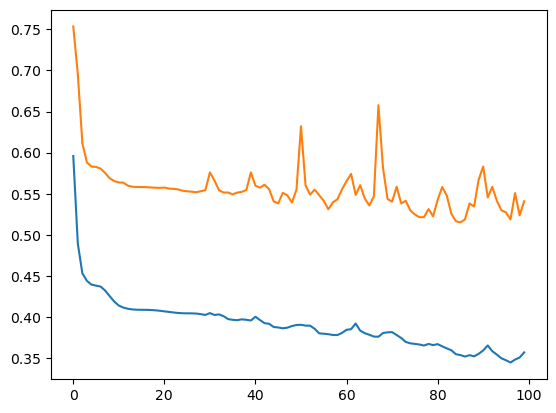

In [7]:
plt.plot(train_score)
plt.plot(val_score)

tensor([[[0., 1., 1.,  ..., 1., 1., 1.],
         [0., 1., 1.,  ..., 1., 1., 1.],
         [0., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]])


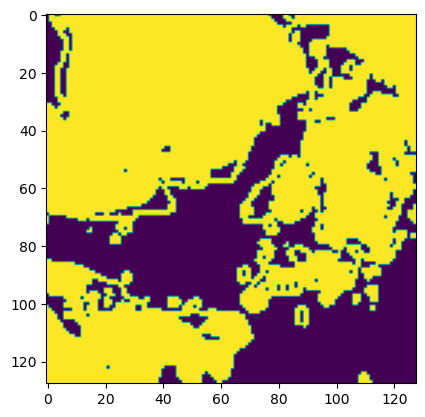

In [9]:
image_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor()])
mask_transforms = transf.Compose([transf.Resize((128,128)), transf.ToTensor(), PixelThreshold(lower_thresh=1, upper_thresh=255)])

#Load our data in our special dataloader
TissTrainData = OcelotDatasetLoader(paths = DATA_PATHS, dataToLoad = 'Tissue', mask_transforms=mask_transforms, image_transforms=image_transforms)

#Load into Pytorch's built in DataLoader
TissTrainLoader = DataLoader(TissTrainData, batch_size=batch_size, num_workers=4)

y_true = TissTrainLoader.dataset[11][1]
y_image = TissTrainLoader.dataset[11][0]
model.to(torch.device(device='cpu'))
y_pred = model(y_image.unsqueeze(0))

print(y_true)

#print(dice_coef(y_pred, y_pred))

y_out = y_true.squeeze().cpu().numpy()
predicted_mask = Image.fromarray((y_out * 255).astype(np.uint8))
#predicted_mask

#dice_coef(y_pred, y_true)
plt.imshow(predicted_mask)

In [6]:
evaluate(model, TissTrainLoader, device=my_device, amp=False)

0.45727431029081345